In [1]:
import pandas as pd
from yelpapi import YelpAPI
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation

import time

%matplotlib inline

/Users/damienrj/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


ISSDTTM and EXPDTTM,which stand for “issued date and time” and “expired date and time”

In [2]:
key_data=pd.read_csv('keys.csv', header=None)
key_data = key_data.set_index(0).transpose()



In [3]:
#This takes about a minute to run because it needs to parse the dates.
temp = pd.read_csv('Food_Establishment_Inspections.csv', low_memory=False,parse_dates=[12], infer_datetime_format=True)

In [4]:
data = temp
data.rename(columns = {'RESULTDTTM':'Date'}, inplace=True)
features = ['BusinessName', 'LegalOwner', 'ViolLevel', 'RESULT', 'Zip', 'Date', 'Address', 'City']

data=data[features]
data.loc[:,'ViolLevel'] = data['ViolLevel'].map({'*': 1, '**': 2, '***':3})

#Remove locations with date error
data = data[(data.RESULT != 'DATAERR') & (data.RESULT != 'HE_OutBus') & (data.RESULT != 'HE_NotReq') & 
            (data.RESULT != 'HE_Misc') & (data.RESULT != 'HE_TSOP')]

data.loc[:,'RESULT'] = data['RESULT'].map({'HE_Closure': 0,'HE_Fail':0,
                    'Fail':0, 'Failed':0, 'HE_FAILNOR':0,
                    'HE_FailExt':0, 'HE_Filed':0,
                    'HE_Hearing':0,'HE_Hold':0,
                    'HE_Pass':1, 'Pass':1})
data.shape

/Users/damienrj/miniconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(335946, 8)

In [5]:
data=data.join(pd.get_dummies(data.ViolLevel).iloc[:,:3])

grouped=data.groupby(['BusinessName', 'Address', 'Date'])

clean_data = grouped.sum()
clean_data.head()


ViolLevel  \
BusinessName              Address              Date                             
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34        NaN   
                                               2010-07-26 10:05:35          6   
                                               2010-08-04 10:11:58          6   
                                               2011-02-09 11:05:14          2   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00        NaN   

                                                                    RESULT  \
BusinessName              Address              Date                          
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34       1   
                                               2010-07-26 10:05:35       0   
                                               2010-08-04 10:11:58       6   
                                               2011-02-09 11:05:14       0   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00       1   

                                                                    1.0  2.0  \
BusinessName              Address              Date                            
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34    0    0   
                                               2010-07-26 10:05:35    6    0   
                                               2010-08-04 10:11:58    6    0   
                                               2011-02-09 11:05:14    2    0   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00    0    0   

                                                                    3.0  
BusinessName              Address              Date                      
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34    0  
                                               2010-07-26 10:05:35    0  
                                               2010-08-04 10:11:58    0  
                                               2011-02-09 11:05:14    0  
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00    0

In [6]:
# grouped.first().Zip

long_clean = clean_data.reset_index()
long_clean['ID'] = long_clean['BusinessName'] +':' + long_clean['Address']

long_clean.head(5)

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID
0,1000 Washington Cafe,1000 Washington ST,2010-03-18 10:05:34,NaN,1,0,0,0,1000 Washington Cafe:1000 Washington ST
1,1000 Washington Cafe,1000 Washington ST,2010-07-26 10:05:35,6,0,6,0,0,1000 Washington Cafe:1000 Washington ST
2,1000 Washington Cafe,1000 Washington ST,2010-08-04 10:11:58,6,6,6,0,0,1000 Washington Cafe:1000 Washington ST
3,1000 Washington Cafe,1000 Washington ST,2011-02-09 11:05:14,2,0,2,0,0,1000 Washington Cafe:1000 Washington ST
4,125 Nashua St. Cafe (MGH),125 Nashua St,2015-07-10 10:59:00,NaN,1,0,0,0,125 Nashua St. Cafe (MGH):125 Nashua St


In [7]:
# create number representing days passed since last inspection date and current inspection date. first entry for a restaurant is set at 0 delta
temp_df = long_clean[['ID', 'Date']]
temp_df.loc[:,'temp_date'] = temp_df['Date']
g = temp_df.groupby(['ID', 'Date'])
delta = g.temp_date.first().diff()

for i in delta.index.levels[0]:
    delta[i][0] = 0  # won't allow np.nan or pd.NaT directly

/Users/damienrj/miniconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [8]:
long_clean['Delta_t']=delta.values

long_clean['Zip'] = grouped.first().Zip.values
long_clean.loc[:,'Delta_t'] = long_clean.Delta_t.dt.days

long_clean=long_clean[~long_clean.Zip.isnull()]
long_clean.RESULT[long_clean.RESULT > 0] = 1

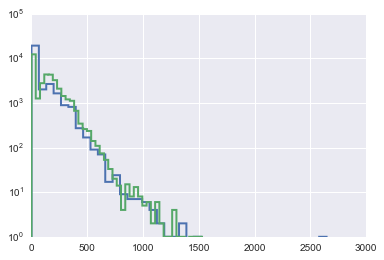

In [9]:
plt.hist(long_clean.Delta_t[long_clean.RESULT>0], 40, histtype='step', lw=2)
plt.hist(long_clean.Delta_t[long_clean.RESULT==0], 40, histtype='step', lw=2)
plt.gca().set_yscale("log")


In [10]:
long_clean[long_clean['BusinessName'].str.contains('Villa Francesca')]

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID,Delta_t,Zip
61605,Villa Francesca,150 RICHMOND,2008-04-30 09:38:15,NaN,1,0,0,0,Villa Francesca:150 RICHMOND,0,02113
61606,Villa Francesca,150 RICHMOND,2008-10-01 12:34:35,1,0,1,0,0,Villa Francesca:150 RICHMOND,154,02113
61607,Villa Francesca,150 RICHMOND,2009-03-24 10:52:50,NaN,1,0,0,0,Villa Francesca:150 RICHMOND,173,02113
61608,Villa Francesca,150 RICHMOND,2009-10-01 11:29:51,2,0,2,0,0,Villa Francesca:150 RICHMOND,191,02113
61609,Villa Francesca,150 RICHMOND,2010-05-27 11:35:39,7,0,4,0,1,Villa Francesca:150 RICHMOND,238,02113
61610,Villa Francesca,150 RICHMOND,2010-06-03 12:29:47,7,1,4,0,1,Villa Francesca:150 RICHMOND,7,02113
61611,Villa Francesca,150 RICHMOND,2010-10-22 10:51:46,3,0,1,1,0,Villa Francesca:150 RICHMOND,140,02113
61612,Villa Francesca,150 RICHMOND,2010-11-05 11:00:02,3,1,1,1,0,Villa Francesca:150 RICHMOND,14,02113
61613,Villa Francesca,150 RICHMOND,2011-11-28 11:05:00,4,0,4,0,0,Villa Francesca:150 RICHMOND,388,02113
61614,Villa Francesca,150 RICHMOND,2011-12-05 10:39:49,4,1,4,0,0,Villa Francesca:150 RICHMOND,6,02113


In [ ]:
taco = long_clean[long_clean['BusinessName'].str.contains('TACO MEX')]
taco['Year'] =  taco.Date.dt.year
taco.RESULT[taco.RESULT > 0] = 1
# taco['Delta_t'] = (taco['Delta_t']/np.timedelta64(1,'D')).astype(int)

# plt.plot(taco.Date.values, taco.ViolLevel.values, 'bo')
# plt.plot(taco.Date[taco.RESULT>0], taco.Delta_t[taco.RESULT>0], '.', markersize=10, label="Pass")
# plt.plot(taco.Date[taco.RESULT==0], taco.Delta_t[taco.RESULT==0]+1, 'rs', markeredgewidth=1, markersize=5, label="Fail")
# plt.xlabel('Time since last inspection')
# plt.ylabel('Date of Inspection')
# plt.title('Taco Mex - History')
# plt.legend(frameon=True)
# plt.savefig('Taco_Mex.pdf')

In [ ]:
delta_pass=taco.Delta_t[taco.RESULT==1]
delta_fail=taco.Delta_t[taco.RESULT==0]

plt.bar([1, 2], [delta_pass.mean(), delta_fail.mean()] ,width=.9,color='b',align='center')
# plt.savefig('TacoMex.pdf')

In [ ]:
delta_pass.mean(), delta_fail.mean()

In [11]:
long_clean.RESULT.sum() / float(long_clean.RESULT.shape[0])

0.43650532323564922

In [12]:
long_clean['Result_last'] = long_clean.groupby(['ID'])['RESULT'].transform(lambda x:x.shift())
long_clean['Date_last'] = long_clean.groupby(['ID'])['Date'].transform(lambda x:x.shift())

long_clean['Result_last'][long_clean.Result_last.isnull()]=-1
long_clean['Date_last'][long_clean.Result_last.isnull()]=-1

long_clean['Day_of_week'] = long_clean.Date_last.dt.dayofweek
long_clean['Month'] = long_clean.Date_last.dt.month
long_clean['Year'] = long_clean.Date_last.dt.year
long_clean['Quarter'] = long_clean.Date_last.dt.quarter

/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
long_clean = long_clean.join(pd.get_dummies(long_clean.Result_last, prefix='Old_Result').iloc[:, 1:3])

In [14]:
long_clean.head()

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID,Delta_t,Zip,Result_last,Date_last,Day_of_week,Month,Year,Quarter,Old_Result_0.0,Old_Result_1.0
0,1000 Washington Cafe,1000 Washington ST,2010-03-18 10:05:34,NaN,1,0,0,0,1000 Washington Cafe:1000 Washington ST,0,02118,-1,NaT,NaN,NaN,NaN,NaN,0,0
1,1000 Washington Cafe,1000 Washington ST,2010-07-26 10:05:35,6,0,6,0,0,1000 Washington Cafe:1000 Washington ST,130,02118,1,2010-03-18 10:05:34,3,3,2010,1,0,1
2,1000 Washington Cafe,1000 Washington ST,2010-08-04 10:11:58,6,1,6,0,0,1000 Washington Cafe:1000 Washington ST,9,02118,0,2010-07-26 10:05:35,0,7,2010,3,1,0
3,1000 Washington Cafe,1000 Washington ST,2011-02-09 11:05:14,2,0,2,0,0,1000 Washington Cafe:1000 Washington ST,189,02118,1,2010-08-04 10:11:58,2,8,2010,3,0,1
4,125 Nashua St. Cafe (MGH),125 Nashua St,2015-07-10 10:59:00,NaN,1,0,0,0,125 Nashua St. Cafe (MGH):125 Nashua St,0,02114,-1,NaT,NaN,NaN,NaN,NaN,0,0


Boston appears to give the same violations with a passed status once the previous violations have been taken care of.

clean_data.groupby(level=0).sum().sort_values(3, ascending=False).head(5)

# Section for pulling data from yelp

In [ ]:
keys = pd.read_csv('keys.csv', header=None)
keys.set_index(0, inplace=True)

keys=keys[1].to_dict()

In [ ]:
resturants = long_clean.groupby('ID').last()
resturants.head()

names = resturants.BusinessName


In [ ]:
yelp_api.search_query(term = '1000 Washington Cafe', location = resturants['Address'][0] + ',Boston, MA ' + resturants['Zip'][0], limit=13, sort = 1)

In [ ]:
names = clean_data.groupby(level=0).groups
names = names.keys()

names[10]

In [ ]:
results = []

for a in xrange(0,len(names)+1 ):
    string ='{}-boston'.format(str.replace(names[a], ' ', '-')).lower()
    string = string.replace("'", '')
    time.sleep(.2)
    try:
        result = yelp_api.business_query(string)
        results.append(result)

    except Exception as e:
        results.append(False)
    


In [ ]:
resturants['yelp']=results

In [15]:
# resturants.to_pickle('YelpDataFrame.p')
resturants=pd.read_pickle('YelpDataFrame.p')

In [16]:
yelp_resturants = resturants[resturants.yelp!=False]
yelp_resturants.reset_index(inplace=True)
yelp_data = yelp_resturants.join(pd.io.json.json_normalize(yelp_resturants.yelp.values))

In [17]:
yelp_data.head(2)

,ID,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,Delta_t,...,phone,rating,rating_img_url,rating_img_url_large,rating_img_url_small,review_count,reviews,snippet_image_url,snippet_text,url
0,224 BOSTON STREET:224 Boston ST,224 BOSTON STREET,224 Boston ST,2015-01-13 14:32:59,9,1,6,0,1,6,...,6172651217,4.0,http://s3-media4.fl.yelpcdn.com/assets/2/www/i...,http://s3-media2.fl.yelpcdn.com/assets/2/www/i...,http://s3-media4.fl.yelpcdn.com/assets/2/www/i...,156,"[{u'rating': 4, u'excerpt': u'Went here last n...",http://s3-media3.fl.yelpcdn.com/photo/n4k57JXW...,Went here last night for my mom's Birthday din...,http://www.yelp.com/biz/224-boston-street-rest...
1,28 DEGREES:1 Appleton ST,28 DEGREES,1 Appleton ST,2012-05-17 12:38:55,9,0,9,0,0,6,...,6177280728,3.5,http://s3-media1.fl.yelpcdn.com/assets/2/www/i...,http://s3-media3.fl.yelpcdn.com/assets/2/www/i...,http://s3-media1.fl.yelpcdn.com/assets/2/www/i...,237,"[{u'rating': 4, u'excerpt': u'I can only speak...",http://s3-media1.fl.yelpcdn.com/photo/DYhpLZ8Z...,I can only speak the the happy hour $1 oyster ...,http://www.yelp.com/biz/28-degrees-boston?utm_...


## This section of the code is for the machine learning

In [19]:
long_clean = long_clean.dropna()
yelp_data = yelp_data[['ID', 'rating', 'location.neighborhoods', 'categories', 'is_closed']]
yelp_data.dropna(inplace=True)
yelp_clean = long_clean.merge(yelp_data, on='ID')
yelp_clean['neighborhoods'] = yelp_clean['location.neighborhoods'].apply(lambda x: x[0])
yelp_clean['type']= yelp_clean['categories'].apply(lambda x: x[0][0])
yelp_clean = yelp_clean.join(pd.get_dummies(yelp_clean.neighborhoods).iloc[:, 0:-1])
yelp_clean = yelp_clean.join(pd.get_dummies(yelp_clean.type).iloc[:, 0:-1])


In [20]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.cross_validation as cv

#Add numberic Bus ID
features = ['Delta_t', 'Day_of_week', 'Month', 'Year', 'Quarter', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0', 'rating', 'Allston/Brighton',
       u'Back Bay', u'Beacon Hill', u'Central Square', u'Charlestown',
       u'Chinatown', u'Dorchester', u'Downtown', u'Dudley Square',
       u'East Boston', u'East Cambridge', u'Fenway', u'Fields Corner',
       u'Financial District', u'Hyde Park', u'Jamaica Plain', u'Mattapan',
       u'Mattapan Square', u'Mission Hill', u'North End', u'Roslindale',
       u'Roslindale Village', u'South Boston', u'South End',
       u'Uphams Corner', u'Waterfront', u'Adult Entertainment', u'African',
       u'American (New)', u'American (Traditional)', u'Asian Fusion',
       u'Bagels', u'Bakeries', u'Bars', u'Bed & Breakfast',
       u'Boat Charters', u'Boating', u'Bookstores', u'Boot Camps',
       u'Brasseries', u'Brazilian', u'Breakfast & Brunch', u'Breweries',
       u'Bubble Tea', u'Buffets', u'Burgers', u'Cafes', u'Cantonese',
       u'Caribbean', u'Caterers', u'Cheesesteaks', u'Chicken Wings',
       u'Chinese', u'Cocktail Bars', u'Coffee & Tea',
       u'Colleges & Universities', u'Colombian', u'Comedy Clubs',
       u'Community Service/Non-Profit', u'Convenience Stores',
       u'Creperies', u'Dance Clubs', u'Delis', u'Desserts', u'Dim Sum',
       u'Diners', u'Dive Bars', u'Do-It-Yourself Food', u'Dominican',
       u'Donuts', u'Drugstores', u'Ethiopian', u'Falafel',
       u'Farmers Market', u'Fast Food', u'Food Stands', u'Food Trucks',
       u'French', u'German', u'Gluten-Free', u'Greek', u'Grocery',
       u'Guest Houses', u'Gyms', u'Health & Medical', u'Hookah Bars',
       u'Hospitals', u'Hotels', u'Ice Cream & Frozen Yogurt', u'Indian',
       u'Indonesian', u'Irish', u'Italian', u'Japanese', u'Jazz & Blues',
       u'Juice Bars & Smoothies', u'Korean', u'Latin American',
       u'Lebanese', u'Lounges', u'Malaysian', u'Mediterranean', u'Mexican',
       u'Middle Eastern', u'Modern European', u'Mongolian', u'Museums',
       u'Music Venues', u'Nightlife', u'Paint & Sip', u'Performing Arts',
       u'Peruvian', u'Pizza', u'Polish', u'Pool Halls', u'Pubs', u'Ramen',
       u'Restaurants', u'Salad', u'Salvadoran', u'Sandwiches', u'Seafood',
       u'Seafood Markets', u'Shoe Stores', u'Soup', u'Southern',
       u'Spanish', u'Specialty Food', u'Sports Bars', u'Steakhouses',
       u'Street Vendors', u'Sushi Bars', u'Szechuan', u'Taiwanese',
       u'Tapas Bars', u'Tex-Mex', u'Thai', u'Tobacco Shops',
       u'Trinidadian', u'Turkish', u'Vegan', u'Venues & Event Spaces',
       u'Vietnamese']

# features = ['Delta_t', 'Day_of_week', 'Month', 'Year', 'Quarter', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0']
# features = ['Delta_t', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0']
#long_clean.RESULT[long_clean.RESULT > 0] = 1

# Xtrain,Xtest,Ytrain,Ytest = cv.train_test_split(long_clean[['Delta_t', 'Zip']],long_clean['RESULT'].values, test_size=0.20)
Xtrain,Xtest,Ytrain,Ytest = cv.train_test_split(yelp_clean[features],yelp_clean['RESULT'].values, test_size=0.20)

In [39]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_leaf=3)
clf.verbose = False
clf.n_jobs = -1
#clf.fit(train[features], np.log1p(train['Sales']))
clf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [ ]:
cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

In [ ]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(n_estimators=2000, max_depth=3)
clf.fit(Xtrain, Ytrain)

In [ ]:
cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=1., solver='lbfgs')
clf.fit(Xtrain, Ytrain)
cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

In [22]:
print(clf.score(Xtest, Ytest))

from sklearn.metrics import f1_score
print(f1_score(Ytest, clf.predict(Xtest)))

0.802485723883
0.745674740484


In [43]:
zip(features, clf.feature_importances_)

[('Delta_t', 0.3123521782879019),
 ('Day_of_week', 0.021848551155485254),
 ('Month', 0.027866134883258554),
 ('Year', 0.035328571821467293),
 ('Quarter', 0.015015777893025545),
 ('Zip', 0.032324562626586575),
 ('Old_Result_0.0', 0.20675958557585286),
 ('Old_Result_1.0', 0.20704791586069263),
 ('rating', 0.022820563934268193),
 ('Allston/Brighton', 0.0012957148960816079),
 (u'Back Bay', 0.0039114992048021689),
 (u'Beacon Hill', 0.0022377441520341854),
 (u'Central Square', 4.573548596469817e-06),
 (u'Charlestown', 0.00070937778885253675),
 (u'Chinatown', 0.0034093078599108958),
 (u'Dorchester', 0.0010992175927551466),
 (u'Downtown', 0.0040696636999535468),
 (u'Dudley Square', 0.00068393969835052492),
 (u'East Boston', 0.0037932201361637746),
 (u'East Cambridge', 9.3657040657671092e-05),
 (u'Fenway', 0.0024152339801590031),
 (u'Fields Corner', 0.00013880852393021147),
 (u'Financial District', 0.0031857338232665409),
 (u'Hyde Park', 0.0012397136896169971),
 (u'Jamaica Plain', 0.00097556335

Also run log regression as one of the models. More assertive language. Pratice resonding to questions, sound confident. What would be ideal, and what are you able to get. What you are trying to get from the comments. Chip review details. Story about travel. 

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Ytest, clf.predict(Xtest), pos_label=1)
auc(fpr, tpr)

In [ ]:
indices = np.argsort(clf.feature_importances_)[::-1]
print("Feature ranking:")

for f in xrange(0, 10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], clf.feature_importances_[indices[f]]))

Graphs for validation and data story

In [23]:
feature_importance = clf.feature_importances_[0:9]
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[9:35]))
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[35:]))

In [ ]:
features_short = [str.join(' ', x.split('_')).title() for x in features_short]

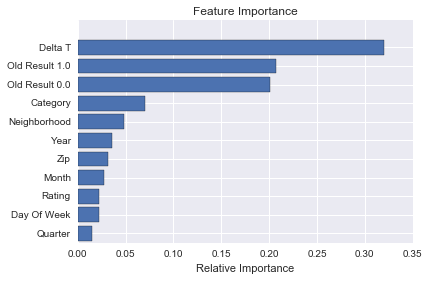

In [24]:
feature_importance = clf.feature_importances_[0:9]
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[9:35]))
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[35:]))
features_short=features[0:9]
features_short.append('Neighborhood')
features_short.append('Category')
features_short = [str.join(' ', x.split('_')).title() for x in features_short]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
labels = [features_short[x] for x in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
# plt.savefig('yelp_importance.pdf', bbox_inches='tight')

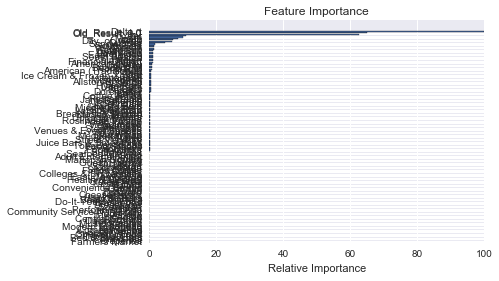

In [25]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
labels = [features[x] for x in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Feature Importance')

# plt.savefig('importance.pdf', bbox_inches='tight')

In [ ]:
sns.set_style("darkgrid")
preds = clf.predict_proba(Xtest)[:,1]
fpr, tpr, _ = roc_curve(Ytest, preds)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC {0:.2f}'.format(auc(fpr, tpr)))

# plt.savefig('yelp_ROC.pdf', bbox_inches='tight')

In [ ]:
plot_data = clean_data.reset_index()
plot_data['Year']=plot_data.Date.dt.year
plot_data.RESULT[plot_data['RESULT'] > 0] = 1
plot_data.groupby('Year').mean().RESULT.plot(fontsize=20)
plt.ylabel("Inspection Pass Rate (%)", fontsize=20)
plt.xlabel('Year', fontsize=20)
# plt.title('Odds of inspection passing')
sns.set_style("darkgrid")
# plt.savefig('PassingRates.pdf', bbox_inches='tight')

In [ ]:
preds.shape

In [ ]:
preds

In [ ]:
clf2 = joblib.load('week2.pkl') 

In [ ]:
clf2.predict(np.array([237, 0, 4, 2014, 2, '02108', 1.0, 0.0]))

In [ ]:
temp = clean_data.groupby(level=0).sum().sort_values(3, ascending=False)
temp.rename(columns={1: '*', 2: '**', 3:'***'}, inplace=True)

ax = temp[['*', '**', '***']][:10].plot(kind = 'bar')
plt.gcf().subplots_adjust(bottom=0.55)
ax.set_ylabel('# Violations')
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.savefig('sample.pdf')

## Move data to remote host

In [26]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

engine = create_engine('postgres://remote@localhost:63333/data')
print engine.url

con = None
con = psycopg2.connect(database = 'data', user = 'remote', port=63333, host='localhost')

# create_database(engine.url)

postgres://remote@localhost:63333/data


In [ ]:
g3 = long_clean.groupby('ID')
server_data = g3.last()
server_data.columns = [str(x).lower() for x in server_data.columns]


In [27]:
g3 = yelp_clean.groupby('ID')
server_data = g3.last()
server_data.columns = [str(x).lower() for x in server_data.columns]
features_low = [str(x).lower() for x in features]

In [ ]:
selected_server_data[(selected_server_data.pass_odds> .30 ) & (selected_server_data.pass_odds < .70)]

This section changes the delta t to the time since the last inspection. It also updates the last results to the last inspection and updates the time, and result columns. 

In [28]:
server_data['delta_t']=pd.to_datetime('2016-01-12')- server_data.date
server_data['delta_t']= (server_data['delta_t']/np.timedelta64(1,'D')).astype(int)
server_data['day_of_week']=server_data.date.dt.dayofweek
server_data['month']=server_data.date.dt.month
server_data['quarter']=server_data.date.dt.quarter
server_data['year']=server_data.date.dt.year

In [32]:
temp = pd.get_dummies(server_data['result'])
server_data['old_result_0.0']=temp[0]
server_data['old_result_1.0']=temp[1]

In [45]:
server_data.head()

,businessname,address,date,viollevel,result,1.0,2.0,3.0,delta_t,zip,...,taiwanese,tapas bars,tex-mex,thai,tobacco shops,trinidadian,turkish,vegan,venues & event spaces,vietnamese
ID,,,,,,,,,,,,,,,,,,,,,
224 BOSTON STREET:224 Boston ST,224 BOSTON STREET,224 Boston ST,2015-01-13 14:32:59,9,1,6,0,1,363,02125,...,0,0,0,0,0,0,0,0,0,0
28 DEGREES:1 Appleton ST,28 DEGREES,1 Appleton ST,2012-05-17 12:38:55,9,0,9,0,0,1334,02116,...,0,0,0,0,0,0,0,0,0,0
303 Cafe:303 Sumner ST,303 Cafe,303 Sumner ST,2011-11-28 08:02:34,11,1,6,1,1,1505,02128,...,0,0,0,0,0,0,0,0,0,0
49 Social:49 Temple PL,49 Social,49 Temple PL,2015-10-30 12:13:33,1,1,1,0,0,73,02111,...,0,0,0,0,0,0,0,0,0,0
5 Napkin Burger:101 Huntington AV,5 Napkin Burger,101 Huntington AV,2015-10-20 12:15:04,2,1,2,0,0,83,02199,...,0,0,0,0,0,0,0,0,0,0


In [44]:
server_data[features_low]

,delta_t,day_of_week,month,year,quarter,zip,old_result_0.0,old_result_1.0,rating,allston/brighton,...,taiwanese,tapas bars,tex-mex,thai,tobacco shops,trinidadian,turkish,vegan,venues & event spaces,vietnamese
ID,,,,,,,,,,,,,,,,,,,,,
224 BOSTON STREET:224 Boston ST,363,1,1,2015,1,02125,0,1,4.0,0,...,0,0,0,0,0,0,0,0,0,0
28 DEGREES:1 Appleton ST,1334,3,5,2012,2,02116,1,0,3.5,0,...,0,0,0,0,0,0,0,0,0,0
303 Cafe:303 Sumner ST,1505,0,11,2011,4,02128,0,1,3.5,0,...,0,0,0,0,0,0,0,0,0,0
49 Social:49 Temple PL,73,4,10,2015,4,02111,0,1,3.5,0,...,0,0,0,0,0,0,0,0,0,0
5 Napkin Burger:101 Huntington AV,83,1,10,2015,4,02199,0,1,3.0,0,...,0,0,0,0,0,0,0,0,0,0
7 Pond Coffee Bar:597 Centre ST,0,0,1,2016,1,02130,1,0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
75 CHESTNUT:75 Chestnut ST,230,1,5,2015,2,02108,1,0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
75 On Liberty Wharf:220 Northern AV,326,3,2,2015,1,02210,1,0,3.5,0,...,0,0,0,0,0,0,0,0,0,0
973 Commonwealth:971 COMMONWEALTH AV,2562,0,1,2009,1,02215,1,0,3.0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
clf.predict_proba(server_data[features_low])

array([[ 0.96364217,  0.03635783],
       [ 0.83281926,  0.16718074],
       [ 0.97255324,  0.02744676],
       ..., 
       [ 0.92448801,  0.07551199],
       [ 0.95504917,  0.04495083],
       [ 0.96699464,  0.03300536]])

In [ ]:
# features_low = ['delta_t', 'day_of_week', 'month', 'year', 'quarter', 'zip', 'old_result_0.0', 'old_result_1.0']
features_low
server_data['pass']=clf.predict(server_data[features_low])
odds = clf.predict_proba(server_data[features_low])
server_data['pass_odds'] = odds[:, 0]
server_data['fail_odds'] = odds[:, 1]
server_data.businessname = server_data.businessname.str.lower()


In [ ]:
selected_server_data= server_data[['businessname', 'address', 'delta_t', 'date', 'pass_odds', 'fail_odds', 'type', 'neighborhoods']]
selected_server_data = selected_server_data[server_data.is_closed == False]
selected_server_data.reset_index(inplace=True)


In [ ]:
selected_server_data.ID = selected_server_data.ID.str.replace("[ ]+", ' ')
selected_server_data.ID = selected_server_data.ID.str.title()

In [ ]:
set(selected_server_data.neighborhoods)

In [ ]:
%%time
selected_server_data.to_sql('yelp', con=engine)

In [47]:
selected_server_data.head()

NameError: name 'selected_server_data' is not defined

In [ ]:
selected_server_data.ID.values[:-1]

In [ ]:
server_data.sort_values('pass_odds')[['businessname', 'address', 'delta_t', 'date', 'pass_odds']][:5].set_index('businessname')

In [ ]:
test=pd.read_sql_query("SELECT * FROM recent WHERE businessname = $$auntie anne's (no. ma 110)$$", engine)

In [ ]:
selected_server_data.sort_values('pass_odds')

In [ ]:
selected_server_data['businessname'][:-1].values

In [ ]:
pd.read_sql("SELECT * FROM recent WHERE businessname = $${}$$".format(temp), engine)

In [ ]:
query = "SELECT * FROM recent WHERE businessname = '{}'".format('129 Lake Street Cafe')
result = pd.read_sql_query(query, engine)
result.fail_odds_odds[0]


In [ ]:
import urlparse
urlparse.uses_query('aramark+%40+sullivan+%26+worcester')